# 🎯 Декларативный Feature Engineering Pipeline

### 📋 Цель
Продемонстрировать работу нового, декларативного пайплайна, который генерирует признаки и целевую переменную на основе единого YAML-конфига.

### 🎯 План выполнения
1. **Импорт библиотек и настройка**
2. **Запуск `FeatureEngineeringPipeline`**:
   - Пайплайн автоматически загрузит данные, построит граф зависимостей признаков из `feature_engineering.yml`, вычислит их и сохранит результат в Parquet.
3. **Анализ созданных признаков**:
   - Проверка формы данных и типов сгенерированных признаков.
4. **Анализ пропущенных значений (Missing Values)**
5. **Очистка и сохранение финального датасета**
6. **Корреляционный анализ**
7. **Подведение итогов**

### 📊 Ожидаемый результат
- **Гибко настраиваемый набор признаков**, определенный в `feature_definitions` в YAML.
- **Целевая переменная `y_bs`**, созданная как часть единого пайплайна.
- **Финальный датасет** в формате Parquet, отфильтрованный согласно активному `feature_set` из YAML.


## 1. Импорт библиотек и настройка


In [13]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Надёжный поиск корня проекта: директория, где есть '03_src' и '01_data'

def _find_project_root(start: Path) -> Path:
    for base in [start] + list(start.parents):
        if (base / '03_src').exists() and (base / '01_data').exists():
            return base
    # fallback: ближайшая директория 'trading_predictor'
    for base in [start] + list(start.parents):
        if base.name == 'trading_predictor':
            return base
    return start

cwd = Path().resolve()
project_root = _find_project_root(cwd)

# Добавляем путь к исходникам
sys.path.append(str(project_root / '03_src'))

print(f"Корневая папка проекта: {project_root}")
print(f"Python version: {sys.version}")


Корневая папка проекта: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor
Python version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


In [14]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import os

# Наши модули
try:
    from features import FeatureEngineeringPipeline  # type: ignore[reportMissingImports]
    
    print("✅ Модули feature engineering успешно импортированы")
except ImportError as e:
    print(f"❌ Ошибка импорта модулей: {e}")
    print("Убедитесь, что все файлы созданы в 03_src/features/")


✅ Модули feature engineering успешно импортированы


In [15]:
# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Настройка графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Настройки применены")


✅ Настройки применены


## 2. Загрузка и предобработка данных


In [16]:
# Использование FeatureEngineeringPipeline для простого запуска
print("🚀 БЫСТРЫЙ СТАРТ С ПАЙПЛАЙНОМ")
print("=" * 40)

# Настраиваем правильные пути (пути в конфиге относительные от корня проекта)
import os
from pathlib import Path
os.chdir(project_root)  # Меняем рабочую директорию на корень проекта
print(f"Текущая рабочая директория: {os.getcwd()}")
print(f"Проверка наличия '01_data': {os.path.exists(str(Path(project_root)/'01_data'))}")

# Инициализация пайплайна (чтение YAML)
pipeline = FeatureEngineeringPipeline(profile="full")
print("✅ Pipeline инициализирован")

# Получаем путь к датасету из YAML
input_rel = (pipeline.config.get('pipeline_settings', {}) or {}).get('input_file')
if not input_rel:
    raise KeyError("В YAML не указан pipeline_settings.input_file")

rel_path = Path(input_rel)
full_path = rel_path if rel_path.is_absolute() else (project_root / rel_path)
print(f"📦 Активный датасет: {(pipeline.config.get('metadata', {}) or {}).get('dataset_name', pipeline.config.get('dataset', {}).get('active', 'dataset'))}")
print(f"Путь к файлу (от корня): {full_path}")
print(f"Проверка наличия файла: {full_path.exists()}")

data_file = str(full_path)
if full_path.exists():
    print(f"✅ Файл данных найден: {rel_path} -> {full_path}")
else:
    # Распечатаем содержимое raw для диагностики (первые 10 файлов)
    raw_dir = project_root / '01_data' / 'raw'
    try:
        listing = list(raw_dir.iterdir())[:10]
        print("Содержимое '01_data/raw' (первые 10):", [p.name for p in listing])
    except Exception as e:
        print(f"Не удалось прочитать директорию {raw_dir}: {e}")
    raise FileNotFoundError(
        f"Требуемый файл не найден по пути: {full_path}\n"
        f"Корень проекта: {project_root}"
    )

🚀 БЫСТРЫЙ СТАРТ С ПАЙПЛАЙНОМ
Текущая рабочая директория: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor
Проверка наличия '01_data': True
✅ Pipeline инициализирован
📦 Активный датасет: EURUSD H1 OANDA (2010–2024)
Путь к файлу (от корня): C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\raw\EURUSD_2010-2024_H1_OANDA.csv
Проверка наличия файла: True
✅ Файл данных найден: 01_data\raw\EURUSD_2010-2024_H1_OANDA.csv -> C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\raw\EURUSD_2010-2024_H1_OANDA.csv


In [17]:
import yaml

# Вспомогательная функция для анализа групп признаков по YAML
def get_feature_groups_from_config(pipeline):
    """
    Читает feature_definitions из YAML и группирует признаки по их "происхождению".
    """
    defs = pipeline.config.get('feature_definitions', {})
    groups = {
        'EMA': [], 'Тренд': [], 'Импульс': [], 'Волатильность/Диапазон': [],
        'Доходности/Статистика': [], 'Прочие': [], 'Календарные': [],
        'База': ['close'], 'Цель': ['y_bs']
    }
    
    # Распределяем по категориям на основе имени и метода
    for name, defn in defs.items():
        if name.startswith('_') or name in ['close', 'y_bs']: continue
        
        if 'ema' in name: groups['EMA'].append(name)
        elif any(k in name for k in ['macd', 'di_diff', 'adx', 'slope']): groups['Тренд'].append(name)
        elif any(k in name for k in ['rsi', 'roc']): groups['Импульс'].append(name)
        elif any(k in name for k in ['atr', 'std', 'range', 'donchian', 'keltner', 'percentB', 'bandwidth']): groups['Волатильность/Диапазон'].append(name)
        elif any(k in name for k in ['ret', 'zscore', 'rolling']): groups['Доходности/Статистика'].append(name)
        elif any(k in name for k in ['vwap', 'psar']): groups['Прочие'].append(name)
        elif any(k in name for k in ['hour', 'dow']): groups['Календарные'].append(name)

    return {k: v for k, v in groups.items() if v}


In [18]:
# Запуск полного пайплайна с указанием файла
print("\nЗапуск полного Feature Engineering...")
df_features, stats = pipeline.run_full_pipeline(input_path=data_file)

print(f"\n🎯 КРАТКИЙ РЕЗУЛЬТАТ:")
print(f"✅ Pipeline завершен успешно!")
print(f"📊 Создано {stats['created_features']} новых признаков")
out_parquet = stats.get('output_path')
if out_parquet:
    print(f"💾 Данные сохранены в: {out_parquet}")


2025-09-22 11:01:07 - FeatureEngineering - INFO - ============================================================
2025-09-22 11:01:07 - FeatureEngineering - INFO - STARTING FULL FEATURE ENGINEERING PIPELINE
2025-09-22 11:01:07 - FeatureEngineering - INFO - ============================================================
2025-09-22 11:01:07 - FeatureEngineering - INFO - Loading data from: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\raw\EURUSD_2010-2024_H1_OANDA.csv



Запуск полного Feature Engineering...


2025-09-22 11:01:07 - FeatureEngineering - INFO - Data loaded successfully. Shape: (88630, 6)
2025-09-22 11:01:07 - FeatureEngineering - INFO - Validating and preparing data...
2025-09-22 11:01:07 - FeatureEngineering - INFO - Auto-mapped columns: {'time': 'Time', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}
2025-09-22 11:01:07 - FeatureEngineering - INFO - Time column converted to datetime index
2025-09-22 11:01:07 - FeatureEngineering - INFO - Data validation completed. Final shape: (88630, 5)
2025-09-22 11:01:07 - FeatureEngineering - INFO - Starting declarative feature pipeline execution...
2025-09-22 11:01:07 - FeatureEngineering - INFO - Execution order determined for 48 features.
2025-09-22 11:01:16 - FeatureEngineering - INFO - Feature set applied: 'fset-4' | Columns kept: 22/34
2025-09-22 11:01:16 - FeatureEngineering - INFO - Saving results...
2025-09-22 11:01:16 - FeatureEngineering - INFO - Full dataset saved to: C:\Users\Shchurov\Хран


🎯 КРАТКИЙ РЕЗУЛЬТАТ:
✅ Pipeline завершен успешно!
📊 Создано 20 новых признаков


## 3. Анализ созданных признаков


In [19]:
# Детальный анализ созданных признаков
print("📊 АНАЛИЗ СОЗДАННЫХ ПРИЗНАКОВ")
print("=" * 40)

# Базовая информация
print(f"Форма данных: {df_features.shape}")
print(f"Период данных: {df_features.index.min()} до {df_features.index.max()}")
print(f"Размер в памяти: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Анализ по типам признаков (динамически из YAML)
groups = get_feature_groups_from_config(pipeline)

print("\n📋 ТИПЫ ПРИЗНАКОВ:")
total_features_in_groups = 0
for name, cols in groups.items():
    existing = [c for c in cols if c in df_features.columns]
    if existing:
        print(f"{name}: {len(existing)}")
        total_features_in_groups += len(existing)

print(f"\nИтого колонок в DataFrame: {len(df_features.columns)}")
print(f"Итого признаков в группах: {total_features_in_groups}")

# Проверка качества данных
missing_count = df_features.isnull().sum().sum()
if df_features.size > 0:
    fill_pct = ((df_features.size - missing_count) / df_features.size) * 100
else:
    fill_pct = 100

print(f"\n🔍 КАЧЕСТВО ДАННЫХ:")
print(f"Пропущенные значения: {missing_count:,}")
print(f"Процент заполненности: {fill_pct:.2f}%")


📊 АНАЛИЗ СОЗДАННЫХ ПРИЗНАКОВ
Форма данных: (88630, 22)
Период данных: 2010-01-03 17:00:00+00:00 до 2023-12-29 21:00:00+00:00
Размер в памяти: 16.55 MB

📋 ТИПЫ ПРИЗНАКОВ:
EMA: 3
Тренд: 3
Импульс: 3
Волатильность/Диапазон: 7
Доходности/Статистика: 3
Прочие: 1
База: 1
Цель: 1

Итого колонок в DataFrame: 22
Итого признаков в группах: 22

🔍 КАЧЕСТВО ДАННЫХ:
Пропущенные значения: 640
Процент заполненности: 99.97%


## 4. Анализ Missing Values

Детальный анализ пропущенных значений в созданном датасете для принятия решения о дальнейшей обработке.


In [20]:
# Детальный анализ Missing Values
print("🔍 АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("=" * 50)

# Общая статистика
total_values = df_features.size
missing_values = df_features.isnull().sum().sum()
missing_percentage = (missing_values / total_values) * 100 if total_values > 0 else 0

print(f"📊 Общая статистика:")
print(f"  • Всего значений: {total_values:,}")
print(f"  • Пропущенных значений: {missing_values:,}")
print(f"  • Процент пропусков: {missing_percentage:.2f}%")

# Анализ по строкам
rows_with_missing = df_features.isnull().any(axis=1).sum()
complete_rows = len(df_features) - rows_with_missing

print(f"\n📈 Анализ по строкам:")
print(f"  • Полные строки (без NaN): {complete_rows:,}")
print(f"  • Строки с пропусками: {rows_with_missing:,}")
print(f"  • Процент полных строк: {(complete_rows/len(df_features)*100):.2f}%" if len(df_features) > 0 else "N/A")

# Анализ по группам (динамически из YAML)
f_groups = get_feature_groups_from_config(pipeline)

print(f"\n🎯 Анализ по типам признаков:")
for group_name, columns in f_groups.items():
    columns = [c for c in columns if c in df_features.columns]
    if columns:
        group_missing = df_features[columns].isnull().sum().sum()
        group_total = df_features[columns].size
        group_percentage = (group_missing / max(group_total, 1)) * 100
        print(f"  • {group_name}: {group_missing:,}/{group_total:,} ({group_percentage:.2f}%)")

# Топ-10 колонок с наибольшим количеством пропусков
print(f"\n🔝 Топ-10 признаков с наибольшим количеством пропусков:")
missing_by_column = df_features.isnull().sum().sort_values(ascending=False)
missing_by_column = missing_by_column[missing_by_column > 0]
print(missing_by_column.head(10))

# Анализ по временным периодам
print(f"\n⏰ Анализ по временным периодам:")
# Первые 1000 строк (начало периода)
early_missing = df_features.head(1000).isnull().sum().sum()
early_total = df_features.head(1000).size
early_percentage = (early_missing / max(early_total, 1)) * 100

# Последние 1000 строк (конец периода)
late_missing = df_features.tail(1000).isnull().sum().sum()
late_total = df_features.tail(1000).size
late_percentage = (late_missing / max(late_total, 1)) * 100

print(f"  • Первые 1000 строк: {early_missing:,}/{early_total:,} ({early_percentage:.2f}%)")
print(f"  • Последние 1000 строк: {late_missing:,}/{late_total:,} ({late_percentage:.2f}%)")

# Рекомендации
print(f"\n💡 РЕКОМЕНДАЦИИ:")
if missing_percentage < 5:
    print("  ✅ Низкий уровень пропусков (<5%) - можно удалить строки с NaN")
elif missing_percentage < 15:
    print("  ⚠️  Средний уровень пропусков (5-15%) - рассмотрите forward fill")
else:
    print("  🔥 Высокий уровень пропусков (>15%) - требуется детальный анализ")

if early_percentage > late_percentage * 2 and early_missing > 0:
    print("  📊 Большинство пропусков в начале - нормально для технических индикаторов")
    print("  💡 Можно удалить первые N строк где слишком много NaN")

print(f"\n🎯 Готов для дальнейшего анализа и принятия решения!")


🔍 АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
📊 Общая статистика:
  • Всего значений: 1,949,860
  • Пропущенных значений: 640
  • Процент пропусков: 0.03%

📈 Анализ по строкам:
  • Полные строки (без NaN): 88,347
  • Строки с пропусками: 283
  • Процент полных строк: 99.68%

🎯 Анализ по типам признаков:
  • EMA: 268/265,890 (0.10%)
  • Тренд: 74/265,890 (0.03%)
  • Импульс: 24/265,890 (0.01%)
  • Волатильность/Диапазон: 184/620,410 (0.03%)
  • Доходности/Статистика: 85/265,890 (0.03%)
  • Прочие: 0/88,630 (0.00%)
  • База: 0/88,630 (0.00%)
  • Цель: 5/88,630 (0.01%)

🔝 Топ-10 признаков с наибольшим количеством пропусков:
f_ema_200              199
f_donchian_pos_20       98
f_zscore_close_50       49
f_ema_50                49
f_macd_12_26_9_hist     33
f_adx_14                27
f_ret_24                24
f_return_std_20         20
f_ema20_slope           20
f_bandwidth_20          19
dtype: int64

⏰ Анализ по временным периодам:
  • Первые 1000 строк: 556/22,000 (2.53%)
  • Последние 1000 строк: 5/2

## 5. Очистка датасета от строк с NaN

Удаление всех строк, содержащих хотя бы одно пропущенное значение, и повторная проверка качества данных.


In [21]:
print("🧹 ОЧИСТКА ДАТАСЕТА ОТ СТРОК С NaN")
print("=" * 50)

from pathlib import Path
import yaml

# Загружаем сохранённый датасет: строго по конфигу YAML (без автопоиска)
parquet_path = stats.get('output_path') if isinstance(stats, dict) else None
if not parquet_path or not Path(parquet_path).exists():
    cfg_path = Path(project_root) / '04_configs' / 'feature_engineering.yml'
    try:
        with open(cfg_path, 'r', encoding='utf-8') as f:
            cfg = yaml.safe_load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Не найден конфиг Feature Engineering: {cfg_path}. Проверьте путь '04_configs/feature_engineering.yml'.")
    ps = (cfg.get('pipeline_settings', {}) or {})
    feature_set = ps.get('feature_set')
    if not feature_set:
        raise KeyError("В конфиге отсутствует 'pipeline_settings.feature_set'. Укажите активный набор признаков (например, 'fset-1').")
    fsets = (cfg.get('feature_sets', {}) or {})
    if feature_set not in fsets:
        raise KeyError(f"Указанный набор признаков '{feature_set}' отсутствует в секции 'feature_sets' файла конфига.")
    output_dir = ps.get('output_dir', '01_data/processed')
    output_pattern = ps.get('output_pattern', '{symbol_lower}_{feature_set}_features.parquet')
    ds = (cfg.get('dataset', {}) or {})
    active = ds.get('active')
    items = (ds.get('items', {}) or {})
    symbol = (items.get(active, {}) or {}).get('symbol', 'ASSET')
    symbol_lower = str(symbol).lower()
    expected = Path(project_root) / output_dir / output_pattern.format(symbol_lower=symbol_lower, feature_set=feature_set)
    parquet_path = str(expected)

if not Path(parquet_path).exists():
    raise FileNotFoundError(
        f"Ожидаемый parquet отсутствует по конфигу: {parquet_path}\n"
        f"Запустите ячейку 6 (пайплайн) для генерации или скорректируйте YAML."
    )

print(f"📂 Загрузка: {parquet_path}")

df_original = pd.read_parquet(parquet_path)
print(f"✅ Загружен оригинальный датасет: {df_original.shape}")

# Статистика ПЕРЕД очисткой
original_missing = df_original.isnull().sum().sum()
original_total = df_original.size
original_missing_pct = (original_missing / original_total) * 100 if original_total > 0 else 0

print(f"\n📊 СТАТИСТИКА ПЕРЕД ОЧИСТКОЙ:")
print(f"  • Общий размер: {df_original.shape}")
print(f"  • Пропущенные значения: {original_missing:,}")
print(f"  • Процент пропусков: {original_missing_pct:.2f}%")
print(f"  • Строки с пропусками: {df_original.isnull().any(axis=1).sum():,}")

# ОЧИСТКА: удаляем строки с любыми NaN
print(f"\n🔥 ВЫПОЛНЯЕТСЯ ОЧИСТКА...")
df_cleaned = df_original.dropna()

# Статистика ПОСЛЕ очистки
cleaned_missing = df_cleaned.isnull().sum().sum()
cleaned_total = df_cleaned.size
cleaned_missing_pct = (cleaned_missing / cleaned_total) * 100 if cleaned_total > 0 else 0

print(f"\n📊 СТАТИСТИКА ПОСЛЕ ОЧИСТКИ:")
print(f"  • Общий размер: {df_cleaned.shape}")
print(f"  • Пропущенные значения: {cleaned_missing:,}")
print(f"  • Процент пропусков: {cleaned_missing_pct:.2f}%")
print(f"  • Удалено строк: {len(df_original) - len(df_cleaned):,}")
print(f"  • Сохранено строк: {len(df_cleaned):,} ({len(df_cleaned)/len(df_original)*100:.2f}%)" if len(df_original) > 0 else "N/A")

# Перезаписываем оригинальный файл очищенным датасетом
print(f"\n💾 СОХРАНЕНИЕ ОЧИЩЕННОГО ДАТАСЕТА...")
df_cleaned.to_parquet(parquet_path)
print(f"✅ Перезаписан файл: {parquet_path}")

# ФИНАЛЬНАЯ ПРОВЕРКА КАЧЕСТВА ДАННЫХ
print(f"\n🔍 КАЧЕСТВО ДАННЫХ:")
print(f"Пропущенные значения: {df_cleaned.isnull().sum().sum():,}")
print(f"Процент заполненности: {100:.2f}%")

print(f"\n🎯 ГОТОВО! Датасет очищен и готов к использованию!")

# Обновляем переменную df_features для дальнейшего использования
df_features = df_cleaned.copy()
print(f"📊 Переменная df_features обновлена: {df_features.shape}")


🧹 ОЧИСТКА ДАТАСЕТА ОТ СТРОК С NaN
📂 Загрузка: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\processed\eurusd_fset-4_features.parquet
✅ Загружен оригинальный датасет: (88630, 22)

📊 СТАТИСТИКА ПЕРЕД ОЧИСТКОЙ:
  • Общий размер: (88630, 22)
  • Пропущенные значения: 640
  • Процент пропусков: 0.03%
  • Строки с пропусками: 283

🔥 ВЫПОЛНЯЕТСЯ ОЧИСТКА...

📊 СТАТИСТИКА ПОСЛЕ ОЧИСТКИ:
  • Общий размер: (88347, 22)
  • Пропущенные значения: 0
  • Процент пропусков: 0.00%
  • Удалено строк: 283
  • Сохранено строк: 88,347 (99.68%)

💾 СОХРАНЕНИЕ ОЧИЩЕННОГО ДАТАСЕТА...
✅ Перезаписан файл: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\processed\eurusd_fset-4_features.parquet

🔍 КАЧЕСТВО ДАННЫХ:
Пропущенные значения: 0
Процент заполненности: 100.00%

🎯 ГОТОВО! Датасет очищен и готов к использованию!
📊 Переменная df_features обновлена: (88347, 22)


## 6. Корреляционный анализ

🔗 КОРРЕЛЯЦИОННЫЙ АНАЛИЗ


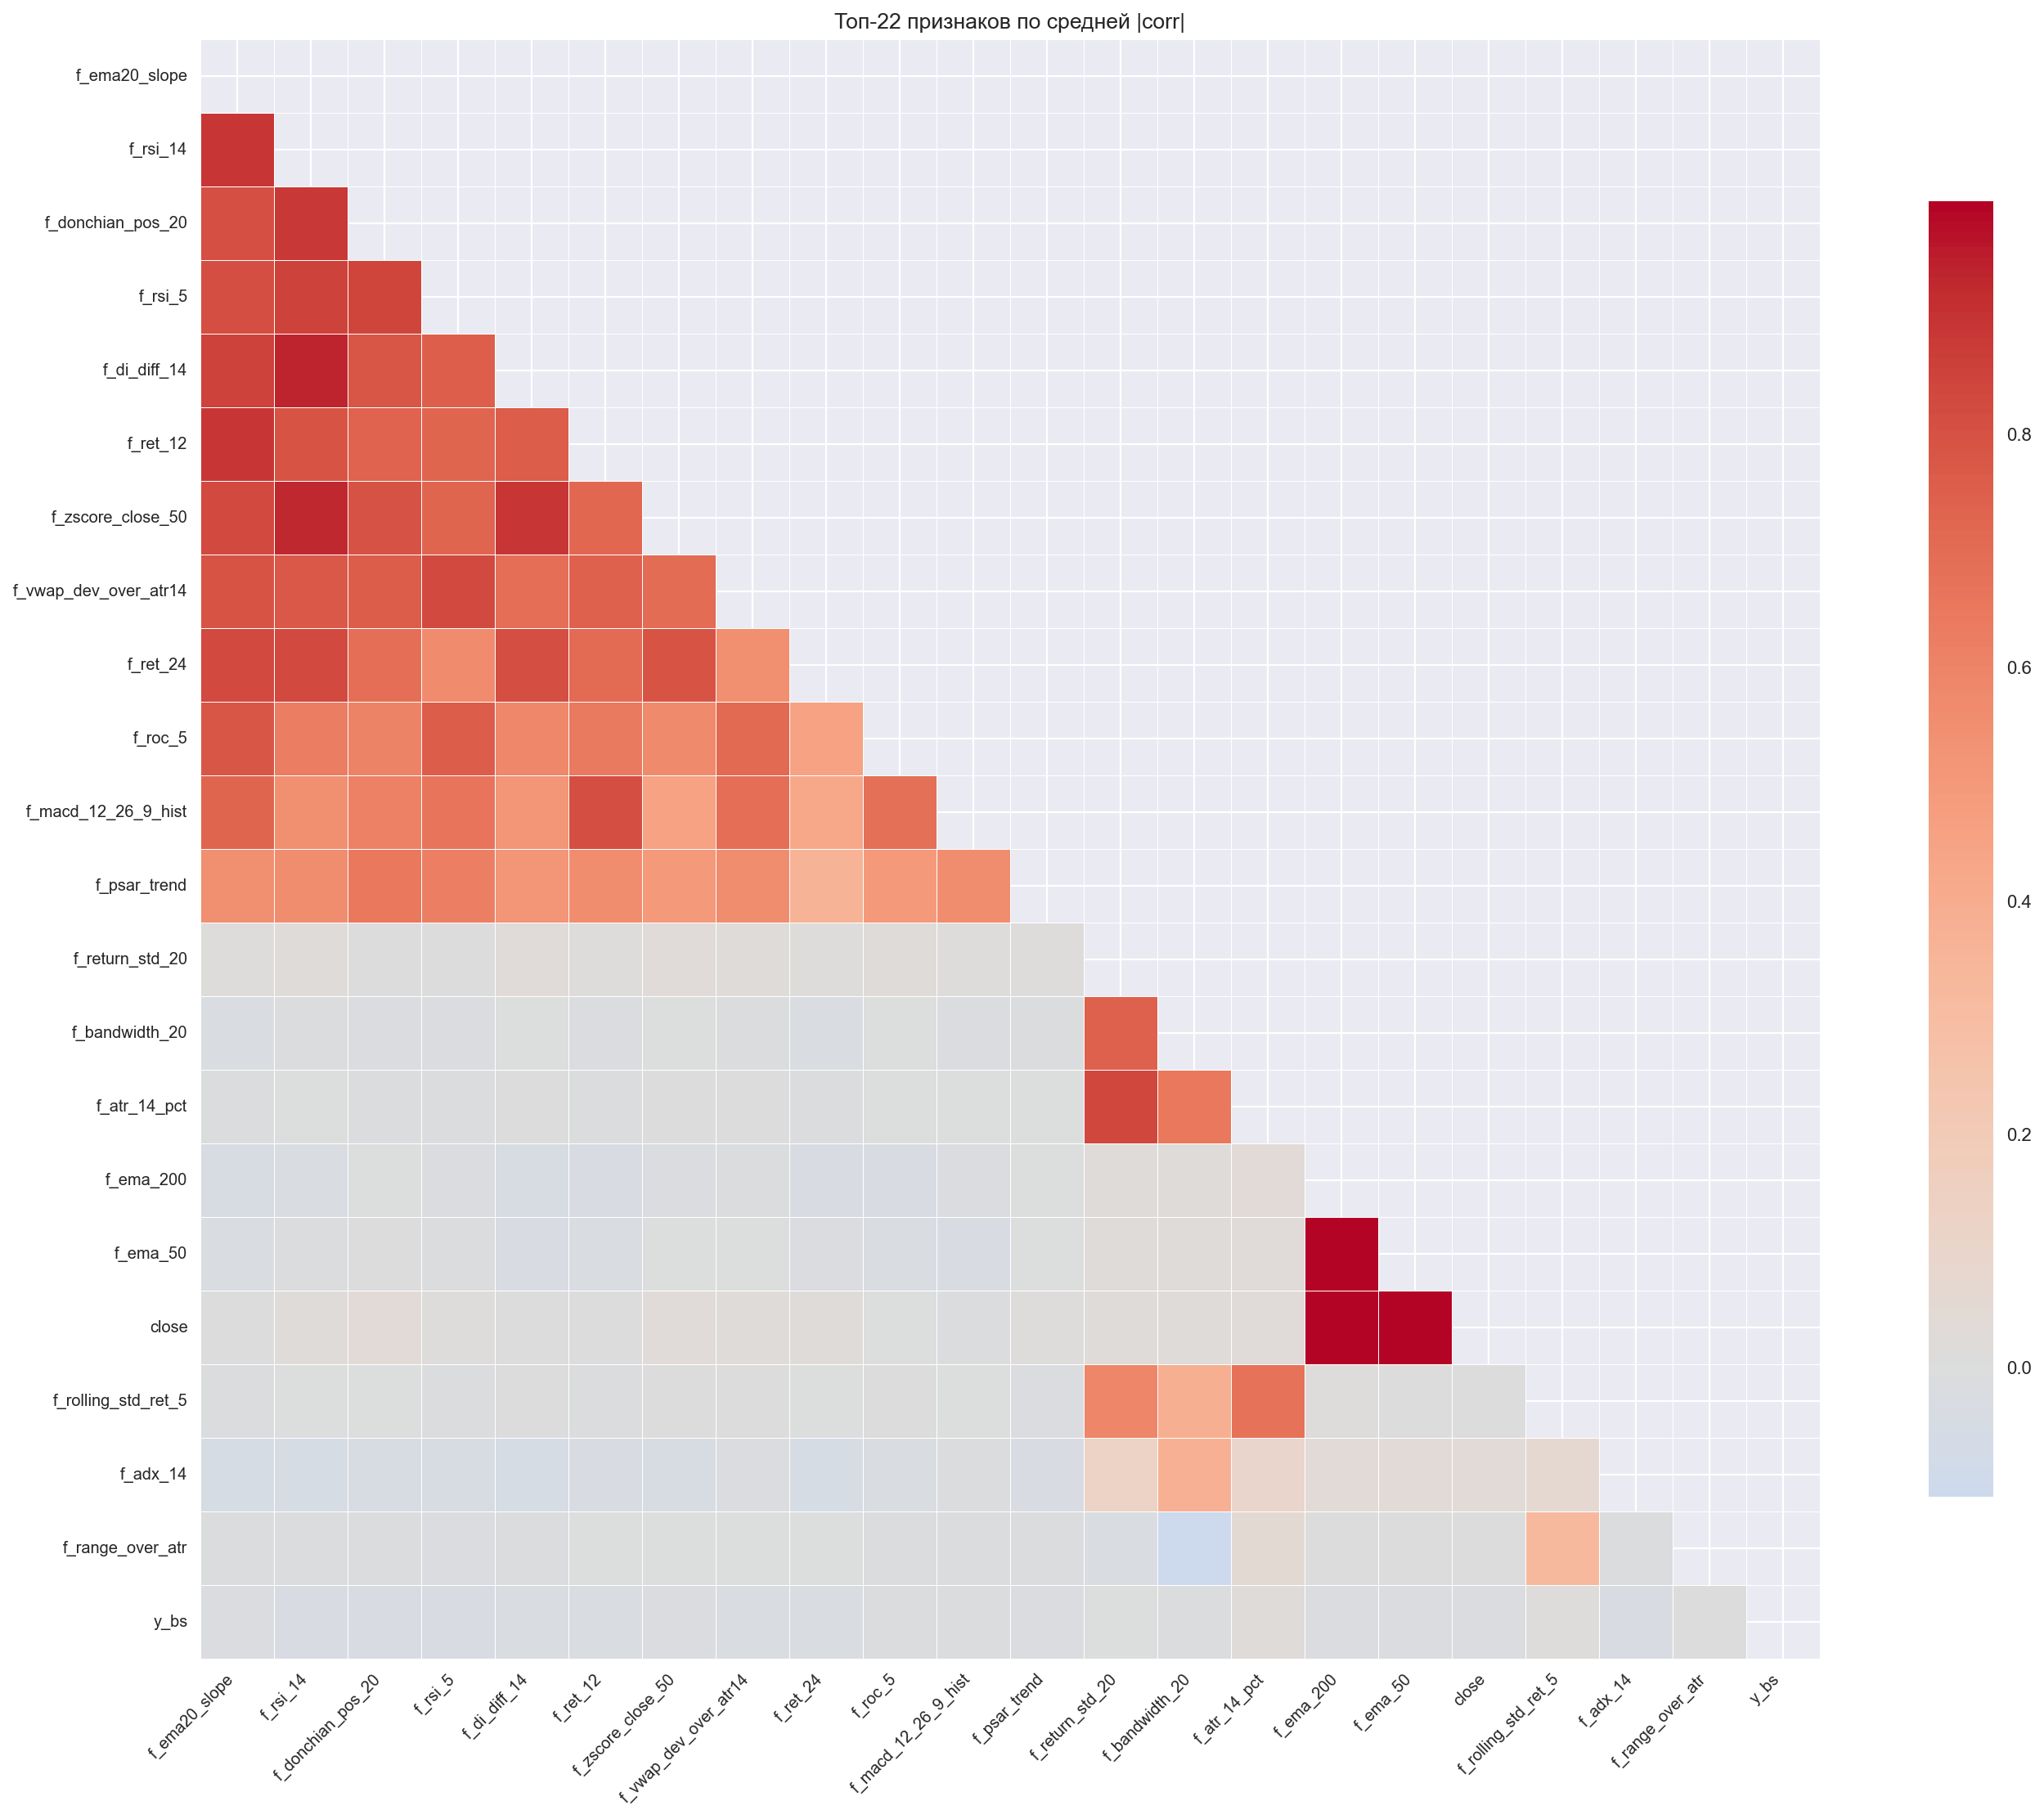

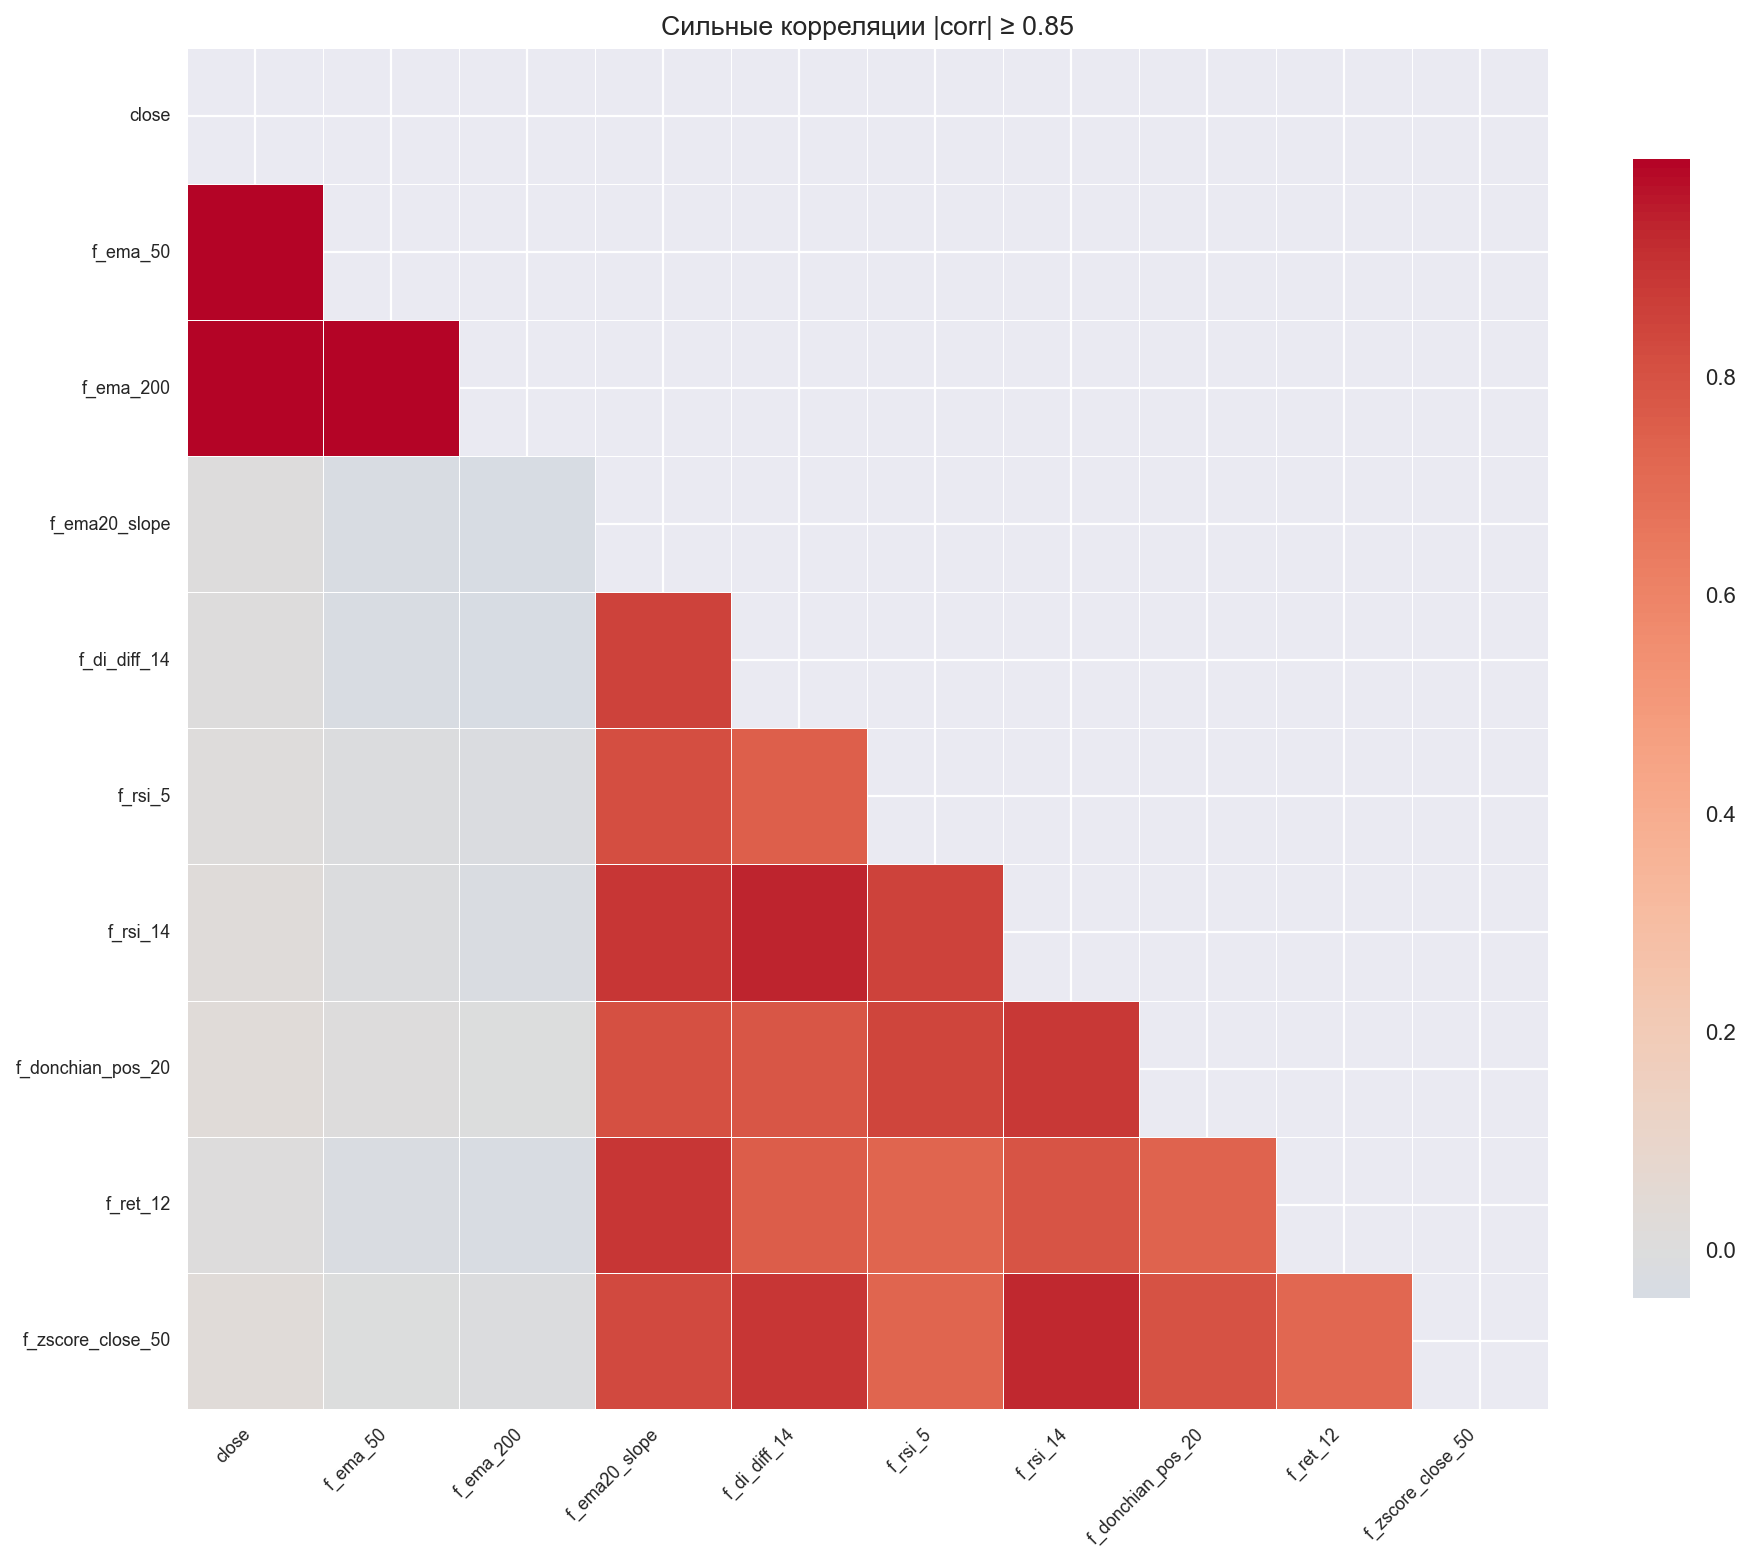


Топ-50 коррелирующих пар (по |corr|):
  close ↔ f_ema_50: 0.999
  f_ema_50 ↔ f_ema_200: 0.999
  close ↔ f_ema_200: 0.997
  f_di_diff_14 ↔ f_rsi_14: 0.940
  f_rsi_14 ↔ f_zscore_close_50: 0.930
  f_ema20_slope ↔ f_ret_12: 0.894
  f_ema20_slope ↔ f_rsi_14: 0.893
  f_di_diff_14 ↔ f_zscore_close_50: 0.892
  f_rsi_14 ↔ f_donchian_pos_20: 0.883
  f_ema20_slope ↔ f_di_diff_14: 0.851
  f_rsi_5 ↔ f_rsi_14: 0.850
  f_rsi_5 ↔ f_donchian_pos_20: 0.847
  f_atr_14_pct ↔ f_return_std_20: 0.838
  f_rsi_5 ↔ f_vwap_dev_over_atr14: 0.831
  f_ema20_slope ↔ f_zscore_close_50: 0.831
  f_ema20_slope ↔ f_ret_24: 0.828
  f_rsi_14 ↔ f_ret_24: 0.827
  f_ema20_slope ↔ f_rsi_5: 0.817
  f_macd_12_26_9_hist ↔ f_ret_12: 0.816
  f_di_diff_14 ↔ f_ret_24: 0.814
  f_ema20_slope ↔ f_donchian_pos_20: 0.807
  f_donchian_pos_20 ↔ f_zscore_close_50: 0.803
  f_ret_24 ↔ f_zscore_close_50: 0.794
  f_ema20_slope ↔ f_vwap_dev_over_atr14: 0.793
  f_rsi_14 ↔ f_ret_12: 0.790
  f_ema20_slope ↔ f_roc_5: 0.784
  f_di_diff_14 ↔ f_donchia

In [22]:
# Корреляционный анализ (все признаки без "каши")
print("🔗 КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

# Гарантируем наличие df_features (подгружаем из parquet при холодном запуске ядра)
try:
    df_features
except NameError:
    parquet_file = stats.get('output_path') if isinstance(stats, dict) else None
    if not parquet_file or not Path(parquet_file).exists():
        cfg_path = Path(project_root) / '04_configs' / 'feature_engineering.yml'
        try:
            with open(cfg_path, 'r', encoding='utf-8') as f:
                cfg = yaml.safe_load(f)
        except FileNotFoundError:
            raise FileNotFoundError(f"Не найден конфиг Feature Engineering: {cfg_path}. Проверьте путь '04_configs/feature_engineering.yml'.")
        ps = (cfg.get('pipeline_settings', {}) or {})
        feature_set = ps.get('feature_set')
        if not feature_set:
            raise KeyError("В конфиге отсутствует 'pipeline_settings.feature_set'. Укажите активный набор признаков (например, 'fset-1').")
        fsets = (cfg.get('feature_sets', {}) or {})
        if feature_set not in fsets:
            raise KeyError(f"Указанный набор признаков '{feature_set}' отсутствует в секции 'feature_sets' файла конфига.")
        output_dir = ps.get('output_dir', '01_data/processed')
        output_pattern = ps.get('output_pattern', '{symbol_lower}_{feature_set}_features.parquet')
        ds = (cfg.get('dataset', {}) or {})
        active = ds.get('active')
        items = (ds.get('items', {}) or {})
        symbol = (items.get(active, {}) or {}).get('symbol', 'ASSET')
        symbol_lower = str(symbol).lower()
        expected = Path(project_root) / output_dir / output_pattern.format(symbol_lower=symbol_lower, feature_set=feature_set)
        parquet_file = str(expected)
    if not Path(parquet_file).exists():
        raise FileNotFoundError(
            f"Ожидаемый parquet отсутствует по конфигу: {parquet_file}\n"
            f"Запустите ячейку 6 (пайплайн) для генерации или скорректируйте YAML."
        )
    df_features = pd.read_parquet(parquet_file)
    print(f"ℹ️ Загружен датасет: {parquet_file} {df_features.shape}")

# Берём только числовые признаки
numeric_df = df_features.select_dtypes(include=[np.number]).copy()

# Сэмплирование для ускорения (если очень большой набор)
if len(numeric_df) > 20000:
    numeric_df_sample = numeric_df.sample(20000, random_state=42)
else:
    numeric_df_sample = numeric_df

# Полная матрица корреляций
corr_full = numeric_df_sample.corr()

# 1) Обзор топ-30 признаков с наибольшей средней |corr| (кроме автокорреляции)
mean_abs_corr = corr_full.abs()
np.fill_diagonal(mean_abs_corr.values, np.nan)
mean_strength = mean_abs_corr.mean().sort_values(ascending=False)

top_n = 30
top_features = mean_strength.head(min(top_n, len(mean_strength))).index
corr_top = corr_full.loc[top_features, top_features]

plt.figure(figsize=(18, 14), dpi=160)
mask = np.triu(np.ones_like(corr_top, dtype=bool))
sns.heatmap(corr_top, mask=mask, cmap='coolwarm', center=0, square=True,
            linewidths=0.4, cbar_kws={"shrink": 0.8})
plt.title(f'Топ-{len(top_features)} признаков по средней |corr|')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# 2) Теплокарта только сильных связей (|corr| >= 0.85)
threshold = 0.85
strong_mask = mean_abs_corr >= threshold
np.fill_diagonal(strong_mask.values, False)
strong_cols = strong_mask.any(axis=0)
strong_rows = strong_mask.any(axis=1)

strong_features = mean_abs_corr.columns[strong_cols | strong_rows]

if len(strong_features) > 1:
    corr_strong = corr_full.loc[strong_features, strong_features]
    plt.figure(figsize=(max(12, 0.35*len(strong_features)), max(10, 0.35*len(strong_features))), dpi=160)
    mask = np.triu(np.ones_like(corr_strong, dtype=bool))
    sns.heatmap(corr_strong, mask=mask, cmap='coolwarm', center=0, square=True,
                linewidths=0.4, cbar_kws={"shrink": 0.8})
    plt.title(f'Сильные корреляции |corr| ≥ {threshold}')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print(f"Сильные корреляции (|corr| ≥ {threshold}) не найдены.")

# 3) Таблица топ-50 пар по |corr|
pairs = []
cols = corr_full.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        pairs.append((cols[i], cols[j], corr_full.iloc[i, j]))

pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print("\nТоп-50 коррелирующих пар (по |corr|):")
for col1, col2, c in pairs_sorted[:50]:
    print(f"  {col1} ↔ {col2}: {c:.3f}")


In [23]:
# Сохранение графиков из корреляционного анализа в 01_data/interim/images/correlation_analysis
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

# Базовая папка изображений
images_base = Path(project_root) / '01_data' / 'interim' / 'images'
corr_dir = images_base / 'correlation_analysis'
corr_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Если переменные не существуют (ячейка анализа не была выполнена), пересчитаем кратко
if not all(k in globals() for k in ('corr_full', 'mean_abs_corr', 'top_features')):
    import pandas as pd
    # гарантируем датасет
    if 'df_features' not in globals():
        parquet_file = stats.get('output_path') if isinstance(stats, dict) else None
        if not parquet_file or not Path(parquet_file).exists():
            cfg_path = Path(project_root) / '04_configs' / 'feature_engineering.yml'
            try:
                with open(cfg_path, 'r', encoding='utf-8') as f:
                    cfg = yaml.safe_load(f)
            except FileNotFoundError:
                raise FileNotFoundError(f"Не найден конфиг Feature Engineering: {cfg_path}. Проверьте путь '04_configs/feature_engineering.yml'.")
            ps = (cfg.get('pipeline_settings', {}) or {})
            feature_set = ps.get('feature_set')
            if not feature_set:
                raise KeyError("В конфиге отсутствует 'pipeline_settings.feature_set'. Укажите активный набор признаков (например, 'fset-1').")
            fsets = (cfg.get('feature_sets', {}) or {})
            if feature_set not in fsets:
                raise KeyError(f"Указанный набор признаков '{feature_set}' отсутствует в секции 'feature_sets' файла конфига.")
            output_dir = ps.get('output_dir', '01_data/processed')
            output_pattern = ps.get('output_pattern', '{symbol_lower}_{feature_set}_features.parquet')
            ds = (cfg.get('dataset', {}) or {})
            active = ds.get('active')
            items = (ds.get('items', {}) or {})
            symbol = (items.get(active, {}) or {}).get('symbol', 'ASSET')
            symbol_lower = str(symbol).lower()
            expected = Path(project_root) / output_dir / output_pattern.format(symbol_lower=symbol_lower, feature_set=feature_set)
            parquet_file = str(expected)
        if not Path(parquet_file).exists():
            raise FileNotFoundError(
                f"Ожидаемый parquet отсутствует по конфигу: {parquet_file}\n"
                f"Запустите ячейку 6 (пайплайн) для генерации или скорректируйте YAML."
            )
        df_features = pd.read_parquet(parquet_file)

    numeric_df = df_features.select_dtypes(include=[np.number]).copy()
    if len(numeric_df) > 20000:
        numeric_df_sample = numeric_df.sample(20000, random_state=42)
    else:
        numeric_df_sample = numeric_df
    corr_full = numeric_df_sample.corr()
    mean_abs_corr = corr_full.abs()
    np.fill_diagonal(mean_abs_corr.values, np.nan)
    mean_strength = mean_abs_corr.mean().sort_values(ascending=False)
    top_n = 30
    top_features = mean_strength.head(min(top_n, len(mean_strength))).index

# 1) Теплокарта топовых признаков
corr_top = corr_full.loc[top_features, top_features]
plt.figure(figsize=(18, 14), dpi=160)
mask = np.triu(np.ones_like(corr_top, dtype=bool))
sns.heatmap(corr_top, mask=mask, cmap='coolwarm', center=0, square=True,
            linewidths=0.4, cbar_kws={"shrink": 0.8})
plt.title(f'Топ-{len(top_features)} признаков по средней |corr|')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
fig1_path = corr_dir / f"fig_corr_top_{len(top_features)}_{timestamp}.png"
plt.savefig(fig1_path, dpi=160, bbox_inches='tight')
print(f"💾 Сохранено: {fig1_path}")
plt.close()

# 2) Теплокарта сильных корреляций (если есть)
threshold = 0.85
strong_mask = mean_abs_corr >= threshold
np.fill_diagonal(strong_mask.values, False)
strong_cols = strong_mask.any(axis=0)
strong_rows = strong_mask.any(axis=1)
strong_features = mean_abs_corr.columns[strong_cols | strong_rows]

if len(strong_features) > 1:
    corr_strong = corr_full.loc[strong_features, strong_features]
    plt.figure(figsize=(max(12, 0.35*len(strong_features)), max(10, 0.35*len(strong_features))), dpi=160)
    mask = np.triu(np.ones_like(corr_strong, dtype=bool))
    sns.heatmap(corr_strong, mask=mask, cmap='coolwarm', center=0, square=True,
                linewidths=0.4, cbar_kws={"shrink": 0.8})
    plt.title(f'Сильные корреляции |corr| ≥ {threshold}')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    fig2_path = corr_dir / f"fig_corr_strong_ge_{threshold}_{timestamp}.png"
    plt.savefig(fig2_path, dpi=160, bbox_inches='tight')
    print(f"💾 Сохранено: {fig2_path}")
    plt.close()
else:
    print(f"Сильные корреляции (|corr| ≥ {threshold}) не найдены — сохранение пропущено.")



💾 Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\interim\images\correlation_analysis\fig_corr_top_22_20250922_110117.png
💾 Сохранено: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\01_data\interim\images\correlation_analysis\fig_corr_strong_ge_0.85_20250922_110117.png


## 7. Подведение итогов

In [24]:
# Финальная сводка и следующие шаги
print("🎉 FEATURE ENGINEERING ЗАВЕРШЕН!")
print("=" * 50)

from pathlib import Path

print(f"✅ Результаты:")
print(f"  • Создано признаков: {stats.get('created_features', 'N/A')}")
print(f"  • Итого колонок: {stats.get('total_columns', 'N/A')}")  
print(f"  • Время выполнения: {stats.get('processing_time', -1):.2f} сек")
print(f"  • Размер данных: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

out_path = stats.get('output_path')
if out_path:
    print(f"\n💾 Сохранено в:")
    print(f"  • {out_path}")

print(f"\n🚀 Готово для:")
print(f"  • Feature Selection")
print(f"  • Обучения ML моделей")
print(f"  • Создания торговых стратегий")
print(f"  • Бэктестинга")

print(f"\n📈 Следующие шаги:")
print(f"  1. Анализ важности признаков")
print(f"  2. Feature Selection (удаление избыточных)")
print(f"  3. Обучение моделей (LSTM, XGBoost, etc.)")
print(f"  4. Валидация и тестирование")

print(f"\n🎯Данные готовы к использованию в ML пайплайнах! 🔥")


🎉 FEATURE ENGINEERING ЗАВЕРШЕН!
✅ Результаты:
  • Создано признаков: 20
  • Итого колонок: 22
  • Время выполнения: 9.07 сек
  • Размер данных: 14.49 MB

🚀 Готово для:
  • Feature Selection
  • Обучения ML моделей
  • Создания торговых стратегий
  • Бэктестинга

📈 Следующие шаги:
  1. Анализ важности признаков
  2. Feature Selection (удаление избыточных)
  3. Обучение моделей (LSTM, XGBoost, etc.)
  4. Валидация и тестирование

🎯Данные готовы к использованию в ML пайплайнах! 🔥
